# Task 2 Encoding and Classifier

## Description

- Encode the following files in a quantum circuit [mock_train_set.csv](https://drive.google.com/file/d/1PIcC1mJ_xi4u1-2gxyoStg2Rg_joSBIB/view?usp=sharing) and [mock_test_set.csv](https://drive.google.com/file/d/1aapYE69pTeNHZ6u-qKAoLfd1HWZVWPlB/view?usp=sharing) in at least two different ways (these could be basis, angle, amplitude, kernel or random encoding).
- Design a variational quantum circuit for each of the encodings, using the `column4` as the target, this is a binary class 0 and 1.
- You must use the data from `column0` to `column3` for your proposed classifier.
- Consider the ansatz you are going to design as a layer and find out how many layers are necessary to reach the best performance.

Analyze and discuss the results.

Feel free to use existing frameworks (e.g. PennyLane, Qiskit) for creating and training the circuits.  
This PennyLane demo can be useful: [Training a quantum circuit with Pytorch](https://pennylane.ai/qml/demos/tutorial_state_preparation.html).  
This Quantum Tensorflow tutorial can be useful: [Training a quantum circuit with Tensorflow](https://www.tensorflow.org/quantum/tutorials/mnist).

For the variational circuit, you can try any circuit you want. You can start from one with a layer of RX, RZ and CNOTs.

In [40]:
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
import pennylane.optimize as optimize

from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## EDA
First, let's load and preprocess the data.

In [2]:
train_data = pd.read_csv("data/mock_train_set.csv")
test_data = pd.read_csv("data/mock_test_set.csv")

print(f"Shape of train data: {train_data.shape}")
print(f"Shape of test data: {test_data.shape}")

Shape of train data: (300, 5)
Shape of test data: (120, 5)


Let's take a closer look at the data, its contents, and data types.

In [3]:
train_data.head()

,0,1,2,3,4
0,2789.26,1000.0,10.0,20.0,0.0
1,4040.01,1000000.0,1.0,1.0,1.0
2,2931.20,10000.0,10000.0,40.0,1.0
3,3896.54,10000.0,100000.0,30.0,1.0
4,982.06,100.0,1000.0,75.0,0.0


In [4]:
test_data.head()

,0,1,2,3,4
0,2988.55,10000.0,10000.0,75.0,1.0
1,3413.80,1.0,100.0,90.0,0.0
2,3891.52,1.0,1.0,5.0,0.0
3,4514.99,10000.0,1000000.0,25.0,1.0
4,752.29,10.0,10.0,90.0,0.0


In [5]:
print(train_data.info())
train_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       300 non-null    float64
 1   1       300 non-null    float64
 2   2       300 non-null    float64
 3   3       300 non-null    float64
 4   4       300 non-null    float64
dtypes: float64(5)
memory usage: 11.8 KB
None


,0,1,2,3,4
count,300.000000,300.000000,300.000000,300.000000,300.000000
mean,2630.877933,308630.410000,127187.050000,46.220000,0.476667
std,1416.096576,460586.067687,314218.134392,27.488488,0.500290
min,42.350000,1.000000,1.000000,1.000000,0.000000
25%,1408.067500,1.000000,10.000000,20.000000,0.000000
50%,2672.180000,1000.000000,1000.000000,50.000000,0.000000
75%,3895.692500,1000000.000000,10000.000000,70.000000,1.000000
max,4995.610000,1000000.000000,1000000.000000,90.000000,1.000000


In [6]:
print(test_data.info())
test_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       120 non-null    float64
 1   1       120 non-null    float64
 2   2       120 non-null    float64
 3   3       120 non-null    float64
 4   4       120 non-null    float64
dtypes: float64(5)
memory usage: 4.8 KB
None


,0,1,2,3,4
count,120.000000,120.000000,120.00000,120.000000,120.000000
mean,2670.297000,301690.150000,185332.30000,47.700000,0.516667
std,1433.466373,459080.909348,377847.18346,27.204362,0.501817
min,31.710000,1.000000,1.00000,1.000000,0.000000
25%,1630.512500,1.000000,10.00000,25.000000,0.000000
50%,2610.575000,1000.000000,1000.00000,50.000000,1.000000
75%,3924.557500,1000000.000000,100000.00000,70.000000,1.000000
max,4913.340000,1000000.000000,1000000.00000,90.000000,1.000000


We can see that the corresponding columns in both train and test data lie in the same ranges. 

Furthermore, by looking at the data distribution of the columns, we can infer that the `column 0` is continuous, `column 1` and `column 2` contain powers of $10$, `column 3` probably contains multiples of $5$, and `column 4` contains binary values (as described in the task).

Now we will verify these points.

Starting with checking which columns are discrete and which are continuous.

In [7]:
print(f"Total rows in train: {len(train_data)}.")
print(f"Unique values in each column:")
print(train_data.nunique())
print()
print(f"Total rows in test: {len(test_data)}.")
print(f"Unique values in each column:")
print(test_data.nunique())

Total rows in train: 300.
Unique values in each column:
0    300
1      6
2      7
3     19
4      2
dtype: int64

Total rows in test: 120.
Unique values in each column:
0    120
1      6
2      7
3     19
4      2
dtype: int64


We can see that only `column 0` has all unique values, and thus it is continuous, while all others are discrete.



Let's also see which columns are all integers.

In [8]:
print("All Integers?")
for i in range(5):
    print(f"Column {i}: {np.array_equal(train_data[str(i)], train_data[str(i)].astype(int))}")


All Integers?
Column 0: False
Column 1: True
Column 2: True
Column 3: True
Column 4: True


We can see that all columns, except `column 0` are integers. 

By looking at the data distribution of `column 1` and `column 2`, it seems that their values can be represented by $10^i$, where $i \in \{0, 1, 2, 3, 4, 5, 6\}$. Let's verify this as well.

In [9]:
def check_col_1_2(data):
    for i in ("1", "2"):
        log10 = np.log10(data[i])
        print(f"Column {i} Min: {log10.min()}")
        print(f"Column {i} Max: {log10.max()}")

print("Training Data")
check_col_1_2(train_data)

print()
print("Testing Data")
check_col_1_2(test_data)

Training Data
Column 1 Min: 0.0
Column 1 Max: 6.0
Column 2 Min: 0.0
Column 2 Max: 6.0

Testing Data
Column 1 Min: 0.0
Column 1 Max: 6.0
Column 2 Min: 0.0
Column 2 Max: 6.0


Now, let's take a look at `column 3` and verify if it only contains $1$ and multiples of $5$.

In [10]:
print(f"Train: {sorted(train_data['3'].unique())}")
print(f"Test:  {sorted(train_data['3'].unique())}")

Train: [1.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0]
Test:  [1.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0]


So, based on our analysis:
- `column 0` is continuous.
- `column 1` and `column 2` contain powers of $10$, ranging from $0$ to $6$.
- `column 3` contains $1$ and multiples of $5$.
- `column 4` is the binary target label.
- All columns, except `column 0`, can be represented by `int64` without any loss of information.

### Data Transformation
Based on the results of our analysis, we can transform our data so it is easier to work with.
- For `column 1` and `column 2`, we take `log10`.
- For `column 3`, we divide by $5$.
- We also convert data types to better represent the data.


In [11]:
def transform_data(data):
    data_new = pd.DataFrame.from_dict(
        {
            0: data['0'],
            1: np.log10(data['1']),
            2: np.log10(data['2']),
            3: data['3'] // 5,
            4: data['4'],
        }
    )

    return data_new.convert_dtypes()

In [12]:
train_transformed = transform_data(train_data)
print(train_transformed.info())
train_transformed.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       300 non-null    Float64
 1   1       300 non-null    Int64  
 2   2       300 non-null    Int64  
 3   3       300 non-null    Int64  
 4   4       300 non-null    Int64  
dtypes: Float64(1), Int64(4)
memory usage: 13.3 KB
None


,0,1,2,3,4
count,300.000000,300.000000,300.000000,300.000000,300.000000
mean,2630.877933,3.116667,2.713333,9.233333,0.476667
std,1416.096576,2.385096,1.999454,5.515459,0.500290
min,42.350000,0.000000,0.000000,0.000000,0.000000
25%,1408.067500,0.000000,1.000000,4.000000,0.000000
50%,2672.180000,3.000000,3.000000,10.000000,0.000000
75%,3895.692500,6.000000,4.000000,14.000000,1.000000
max,4995.610000,6.000000,6.000000,18.000000,1.000000


### Visualizations
Now, let's take a quick look at some visualizations of the transformed data to get a better sense of the data and its distribution.

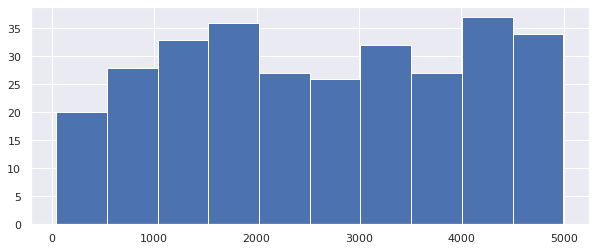

In [92]:
# column 0
train_transformed[0].hist(
    figsize=(10, 4),
);


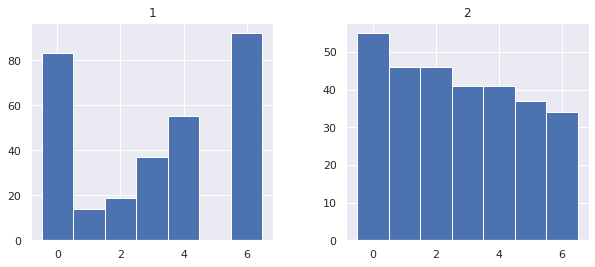

In [93]:
# columns 1, 2
train_transformed[[1, 2]].hist(
    figsize=(10, 4),
    bins=[x - 0.5 for x in range(8)]
);

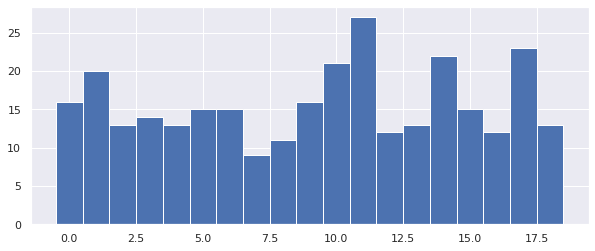

In [94]:
# print(f"column 3:")
train_transformed[3].hist(
    figsize=(10, 4),
    bins=[x - 0.5 for x in range(20)],
);

## Data Encoding
Now that we have processed the data, let's move on to the actual task of Data Encoding. For this purpose, we'll use the `Embedding Templates` defined in the [PennyLane](https://pennylane.readthedocs.io/en/stable/introduction/templates.html) library. This includes, but not limited to
- [Basis Embedding](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.BasisEmbedding.html): Encodes $n$ binary features into a basis state of $n$ qubits.
- [Amplitude Embedding](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.AmplitudeEmbedding.html): Encodes $2^n$ features into the amplitude vector of $n$ qubits.
- [Angle Embedding](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.AngleEmbedding.html): Encodes $N$ features into the rotation angles of $n$ qubits, where $N ≤ n$.

There are other more advanced embedding techniques available as well, but only be using these one for this specific exercise. Let's data a look at the data to figure out how best to represent each feature and how to normalize it.

In [16]:
train_transformed[range(4)].describe()

,0,1,2,3
count,300.000000,300.000000,300.000000,300.000000
mean,2630.877933,3.116667,2.713333,9.233333
std,1416.096576,2.385096,1.999454,5.515459
min,42.350000,0.000000,0.000000,0.000000
25%,1408.067500,0.000000,1.000000,4.000000
50%,2672.180000,3.000000,3.000000,10.000000
75%,3895.692500,6.000000,4.000000,14.000000
max,4995.610000,6.000000,6.000000,18.000000


Given that the `BasisEmbedding` requires $n$ qubits to encode $n$ binary features, it's not a very feasible approach for this dataset, except maybe for `column 1` and `column 2`, so for now, we'll resort to using `AmplitudeEmbedding`, `AngleEmbedding`, and their permutations. We will see which one gives a better result.

We'll also need to normalize the features as well. We can do so by dividing the feature by the maximum possible value of that feature and then multiply it by a $\pi$.

### Embedding Schemes
Now, let's define some functions that implement embedding schemes to encode the data. If we denote `AngularEmbedding` as `N` and `AmplitudeEmbedding` as `A`, then we can encode the four features using:
- `N N N N`
- `A A A A`
- `N A A N`
- `A N N A`

Other permutations of these are also possible, but for the sake of this experiment, this is enough.

Now let's define some functions that implement these encoding schemes.

In [17]:
max_values = list(np.max(train_transformed[range(4)], axis=0))
print(f"Maximum values of each feature: {max_values}")

Maximum values of each feature: [4995.61, 6.0, 6.0, 18.0]


In [18]:
def NNNN(x):
    norm_x = x / max_values * np.pi

    for i, f in enumerate(norm_x):
        qml.AngleEmbedding(
            features=[f],
            wires=[i, ],
            rotation='X'
        )

In [19]:
def AAAA(x):
    norm_x = x / max_values * np.pi
    
    qml.AmplitudeEmbedding(
        features=norm_x,
        wires=[0, 1],
        normalize=True
    )

In [20]:
def NAAN(x):
    norm_x = x / max_values * np.pi
    norm_x[1] = norm_x[1] + 1 #so both features (1, 2) aren't 0 at the same time.

    qml.AngleEmbedding(
        features=[norm_x[0]],
        wires=[0,],
        rotation='X'
    )
    qml.AmplitudeEmbedding(
        features=norm_x[1:3],
        wires=[1,],
        normalize=True
    )
    qml.AngleEmbedding(
        features=[norm_x[3]],
        wires=[2,],
        rotation='X'
    )

In [43]:
def ANNA(x):
    norm_x = x / max_values * np.pi
    norm_x[0] = norm_x[0] + 1 #so both features (0, 3) aren't 0 at the same time.

    qml.AmplitudeEmbedding(
        features=np.array([norm_x[0], [x[3]]]),
        wires=[0,],
        normalize=True
    )
    qml.AngleEmbedding(
        features=[norm_x[1]],
        wires=[1,],
        rotation='X'
    )
    qml.AngleEmbedding(
        features=[norm_x[2]],
        wires=[2,],
        rotation='X'
    )

### Training and Utility Functions
Let's defined the pipeline that we'll use to train our classifiers. Masjor parts of this are taken from the [Variational Classifier tutorial](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html) and modified for our current task. 

We will define the `circuit` later on below.

In [22]:
def variational_classifier(weights, bias, features):
    return circuit(weights, features) + bias


def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss


def accuracy(labels, predictions):
    num_correct = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            num_correct += 1
    
    num_correct /= len(labels)
    return num_correct


def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

#### Train/Val Split
Let's split the data into training and validation datasets.

In [23]:
X_full = train_transformed[range(4)].to_numpy()
y_full = train_transformed[4].to_numpy() 

# transform labels from {0, 1} to {-1, 1}
y_full = y_full * 2 - 1 

X_full = np.array(X_full, requires_grad=False)
y_full = np.array(y_full, requires_grad=False)

full_size = len(X_full)
print(f"Full data size: {full_size}")

# Use 2/3 of the data for traning and the rest for validation
num_train = int(2 / 3 * full_size)

# fix the seed
np.random.seed(42)

index = np.random.permutation(range(full_size))

X_train = X_full[index[:num_train]]
y_train = y_full[index[:num_train]]
X_val = X_full[index[num_train:]]
y_val = y_full[index[num_train:]]

print(f"Train size: {len(X_train)} = {len(X_train) / full_size * 100:0.3}%")
print(f"Valid size: {len(X_val)} = {len(X_val) / full_size * 100:0.3}%")

Full data size: 300
Train size: 200 = 66.7%
Valid size: 100 = 33.3%


#### Train/Validation Loop
Instead of focusing too much on the hyperparameters of the training logic, we will simply follow the practices used in the [Variational Classifier tutorial](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html). This would allow us to focus more on the actual task of figuring out a better embedding strategy and ansatz for classification.

In [24]:
def plot_cost_acc(
    iterations,
    loss,
    train_acc,
    val_acc,
    plot_title
):
    fig, (ax_cost, ax_acc) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=[14, 3])
    
    ax_cost.plot(iterations, loss, 'C0', ls='-', label='loss')
    ax_cost.set_xlabel('iteration')
    ax_cost.set_ylabel('loss')

    ax_acc.plot(iterations, train_acc, 'C0', ls='-', label='train accuracy')
    ax_acc.plot(iterations, val_acc, 'C1', ls='-', label='val accuracy')
    ax_acc.set_ylim(bottom=0, top=1)
    ax_acc.set_xlabel('iteration')
    ax_acc.set_ylabel('accuracy')
    
    ax_acc.legend()
    fig.suptitle(plot_title)
    plt.show()

In [25]:
def train_val_loop(
    weights_shape,
    label,
    w_init=0.01,
    step_size=0.01,
    batch_size=20,
    num_iter=200,
    validate_every=2
):
    weights_init = w_init * np.random.randn(*weights_shape, requires_grad=True)
    bias_init = np.array(0.0, requires_grad=True)

    opt = optimize.NesterovMomentumOptimizer(step_size)
    
    # train the variational classifier
    weights = weights_init
    bias = bias_init

    iterations = []
    losses = []
    train_acc = []
    val_acc = []

    for i in tqdm(range(num_iter)):
        batch_index = np.random.randint(0, num_train, (batch_size,))
        X_train_batch = X_train[batch_index]
        y_train_batch = y_train[batch_index]
        # Update the weights by one optimizer step
        weights, bias, _, _ = opt.step(cost, weights, bias, X_train_batch, y_train_batch)

        if i % validate_every == 0:
            iterations.append(i)
            
            # Compute predictions on train and validation set
            predictions_train = [
                np.sign(variational_classifier(weights, bias, f)) for f in X_train
            ]
            predictions_val = [
                np.sign(variational_classifier(weights, bias, f)) for f in X_val
            ]

            losses.append(cost(weights, bias, X_full, y_full))
            
            # Compute accuracy on train and validation set
            train_acc.append(accuracy(y_train, predictions_train))
            val_acc.append(accuracy(y_val, predictions_val))
    
    plot_cost_acc(iterations, losses, train_acc, val_acc, label)
    return weights, bias

## Variational Circuits
Now our task is to design variational quantum circuits for each of the embeddings and see which one performs better and how many layers are necessary to reach the best performance.

We will start off by using a simple ansatz with `RX, RY, RZ` and `CNOT` gates, as mentioned in the task description. After that, we'll try the [BasicEntanglerLayers](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.BasicEntanglerLayers.html?highlight=basicentan#pennylane.BasicEntanglerLayers) defined in the PennyLane which consists of one-parameter single-qubit rotations on each qubit, followed by a closed chain of CNOT gates. By default, it uses the `RX` gate. The number of layers $L$ is determined by the first dimension of the argument `weights`.  
![](https://pennylane.readthedocs.io/en/stable/_images/basic_entangler.png) 

### `RX`, `RY`, `RZ`, and `CNOT`
We will start by using this circuit to evaluate different embedding strategies. After that, we'll use the best resulting strategy to evaluate and compare this circuit with `BasicEntanglerLayers`.

In [33]:
# a layer of the circuit ansatz
def layer(weights, j):
    num_wires = weights.shape[0]
    for i in range(num_wires):
        qml.RX(weights[i, j, 0], wires=i)
        qml.RY(weights[i, j, 1], wires=i)
        qml.RZ(weights[i, j, 2], wires=i)

    for i in range(num_wires - 1):
        qml.CNOT(wires=[i, i + 1])
    
    if num_wires > 2:
        qml.CNOT(wires=[0, num_wires - 1])

In [42]:
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def circuit(weights, features):

    AAAA(features)

    # repeatedly apply each layer in the circuit
    for i in range(weights.shape[1]):
        layer(weights, i)

    return qml.expval(qml.PauliZ(0))

100%|██████████| 200/200 [08:01<00:00,  2.41s/it]


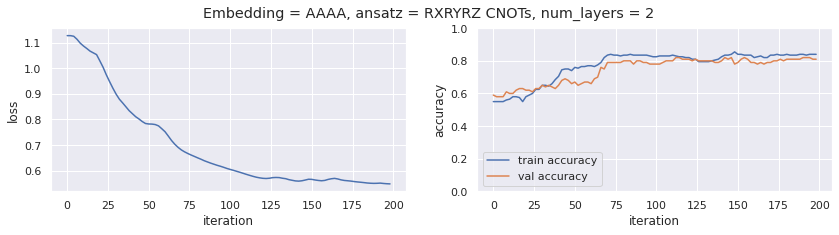

100%|██████████| 200/200 [14:12<00:00,  4.26s/it]


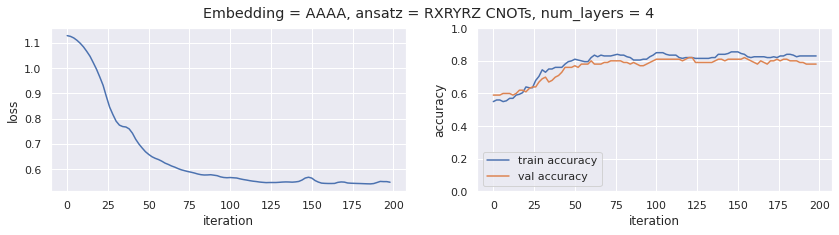

100%|██████████| 200/200 [20:01<00:00,  6.01s/it]


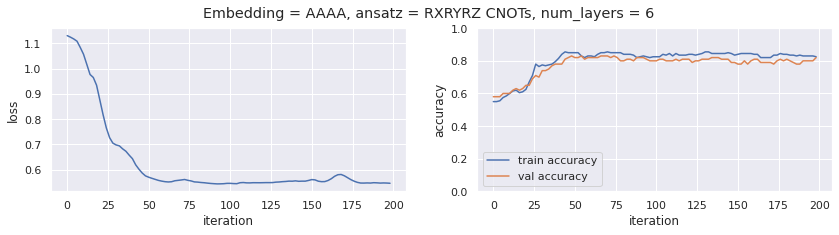

In [43]:
for num_layers in (2, 4, 6):
    train_val_loop(
        weights_shape=(dev.num_wires, num_layers, 3),
        label=f"Embedding = AAAA, ansatz = RXRYRZ CNOTs, num_layers = {num_layers}"
    )

From the plots above, we can see that all of the layers give an accuracy above $80 \%$. We also see that increasing the number of layers results in longer-training time, but quick convergence. For 2 layers, the loss was relatively stable around $150$ iterations, for 4 layers around $100$, and for 6 layers around $50$.

| num_layers | training time (MM:SS) |
| -----------|-----------------------|
| 2          | 08:01                 |
| 4          | 14:12                 |
| 6          | 20:01                 |

Moving forward, we'll reduce the training iterations to $150$ to somewhat reduce the training time.

In [28]:
dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev)
def circuit(weights, features):

    NNNN(features)

    # repeatedly apply each layer in the circuit
    for i in range(weights.shape[0]):
        layer(weights, i)

    return qml.expval(qml.PauliZ(0))

100%|██████████| 150/150 [13:15<00:00,  5.30s/it]


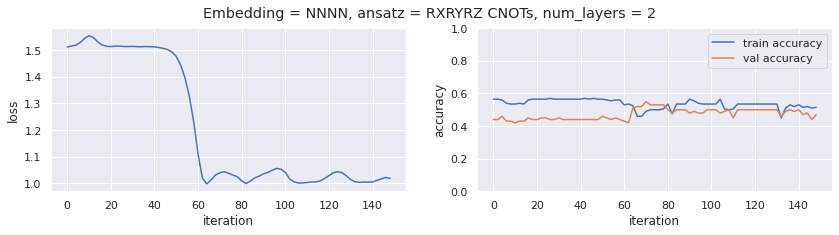

100%|██████████| 150/150 [23:11<00:00,  9.28s/it]


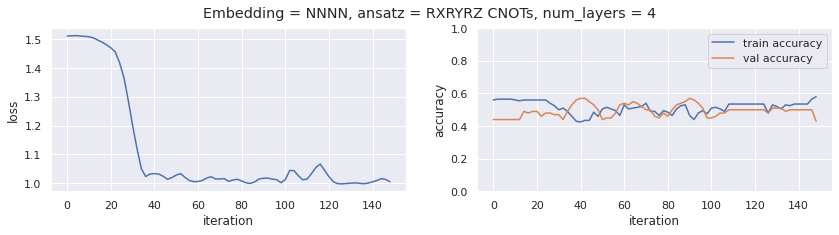

In [29]:
for num_layers in (2, 4):
    train_val_loop(
        weights_shape=(num_layers, dev.num_wires, 3),
        label=f"Embedding = NNNN, ansatz = RXRYRZ CNOTs, num_layers = {num_layers}",
        num_iter=150
    )

We can see that the Angular Embedding doesn't work very well in this case. The training algorithm wasn't able to learn much, as evident from the cost and accuracy curves.


In [49]:
dev = qml.device('default.qubit', wires=3)

@qml.qnode(dev)
def circuit(weights, features):

    NAAN(features)

    # repeatedly apply each layer in the circuit
    for j in range(weights.shape[1]):
        layer(weights, j)

    return qml.expval(qml.PauliZ(0))

100%|██████████| 150/150 [09:57<00:00,  3.99s/it]


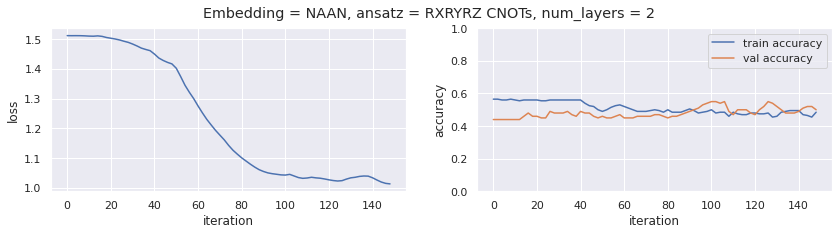

100%|██████████| 150/150 [17:31<00:00,  7.01s/it]


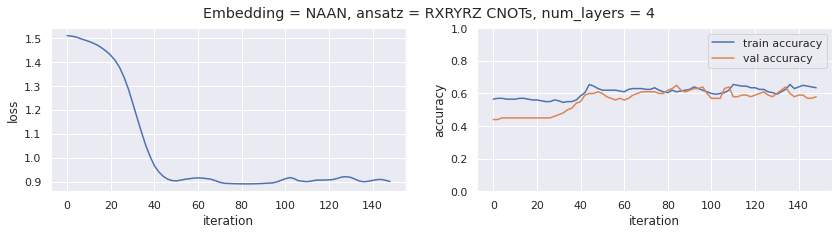

100%|██████████| 150/150 [24:51<00:00,  9.94s/it]


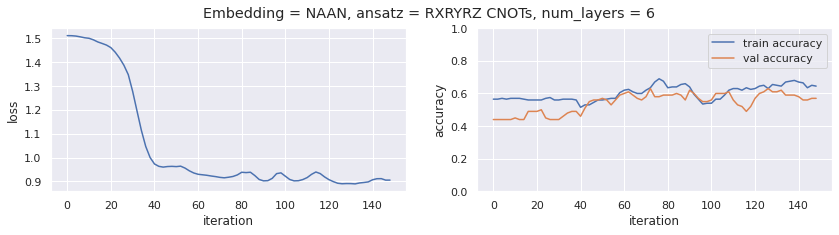

In [50]:
for num_layers in (2, 4, 6):
    train_val_loop(
        weights_shape=(dev.num_wires, num_layers, 3),
        label=f"Embedding = NAAN, ansatz = RXRYRZ CNOTs, num_layers = {num_layers}",
        num_iter=150
    )

Again, this embedding scheme doesn't seem to work well as well. The cost and accuracy curves suggest poor learning capability of the model.

| num_layers | training time (MM:SS) |
| -----------|-----------------------|
| 2          | 09:57                 |
| 4          | 17:31                 |
| 6          | 24:51                 |

In [47]:
dev = qml.device('default.qubit', wires=3)

@qml.qnode(dev)
def circuit(weights, features):

    ANNA(features)

    # repeatedly apply each layer in the circuit
    for i in range(weights.shape[1]):
        layer(weights, i)

    return qml.expval(qml.PauliZ(0))

100%|██████████| 150/150 [10:10<00:00,  4.07s/it]


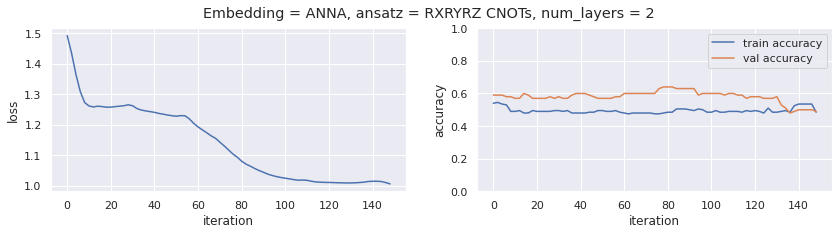

100%|██████████| 150/150 [17:27<00:00,  6.98s/it]


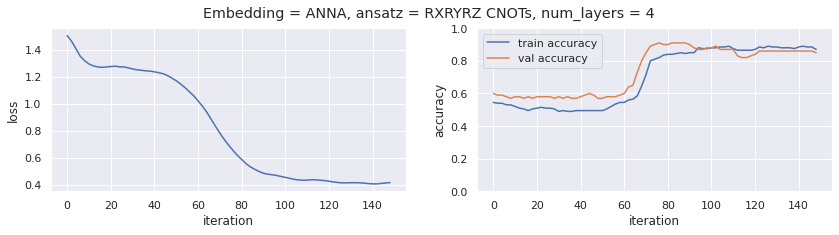

In [48]:
for num_layers in (2, 4):
    train_val_loop(
        weights_shape=(dev.num_wires, num_layers, 3),
        label=f"Embedding = ANNA, ansatz = RXRYRZ CNOTs, num_layers = {num_layers}",
        num_iter=150
    )

This embedding scheme is giving the best results so far, for this ansatz. For 2 layers, the model isn't able to learn well, but for 4 layers, it's giving an accuracy $> 80\%$.

### BasicEntanglerLayers
Now, let's check the embedding schemes on the `BasicEntanglerLayers` provided by the PennyLane.

We'll again run and compare the results on different embedding schemes and number of layers.

In [51]:
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def circuit(weights, features):
    AAAA(features)

    qml.BasicEntanglerLayers(weights, wires=range(dev.num_wires))

    return qml.expval(qml.PauliZ(0))

100%|██████████| 200/200 [04:43<00:00,  1.42s/it]


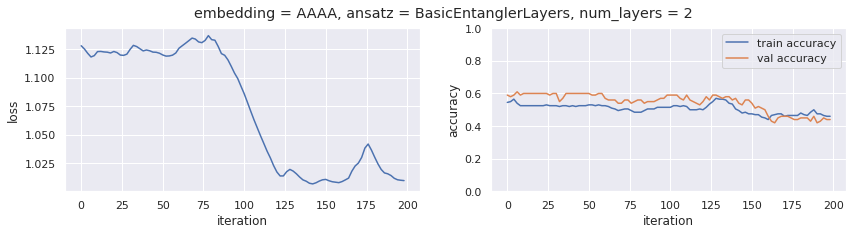

100%|██████████| 200/200 [07:15<00:00,  2.18s/it]


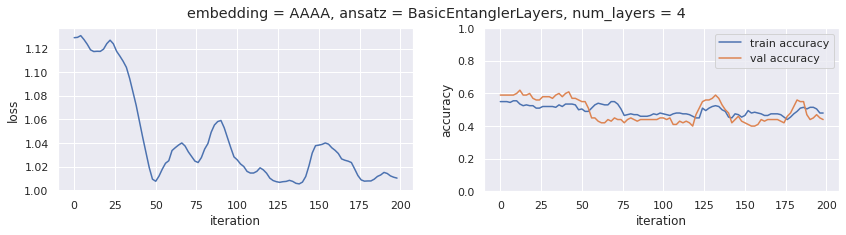

100%|██████████| 200/200 [09:42<00:00,  2.91s/it]


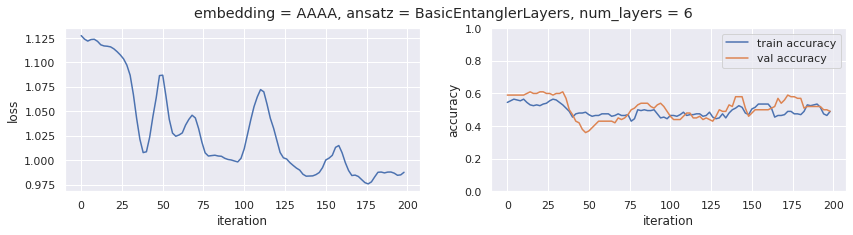

In [52]:
for num_layers in (2, 4, 6):
    train_val_loop(
        weights_shape=(num_layers, dev.num_wires),
        label=f"embedding = AAAA, ansatz = BasicEntanglerLayers, num_layers = {num_layers}"
    )

The Amplitude Embedding doesn't seem to work well with this circuit. We won't be using this later.

In [53]:
dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev)
def circuit(weights, features):
    NNNN(features)

    qml.BasicEntanglerLayers(weights, wires=range(dev.num_wires))

    return qml.expval(qml.PauliZ(0))

100%|██████████| 200/200 [09:19<00:00,  2.80s/it]


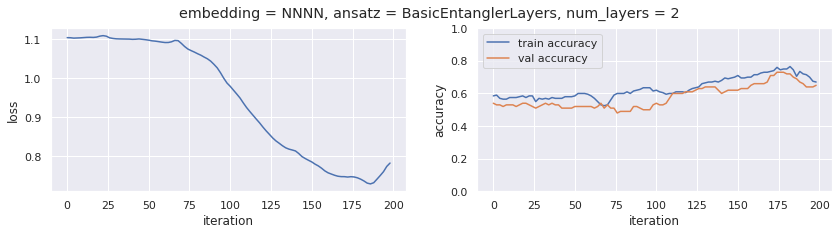

100%|██████████| 200/200 [14:48<00:00,  4.44s/it]


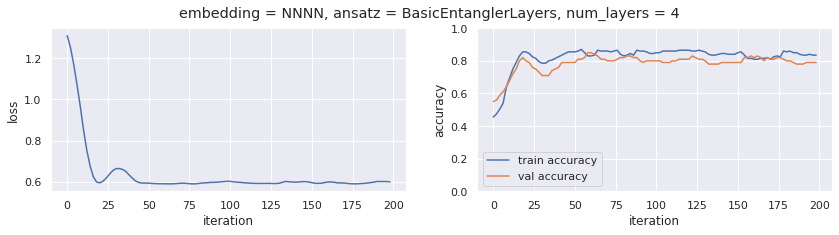

100%|██████████| 200/200 [20:13<00:00,  6.07s/it]


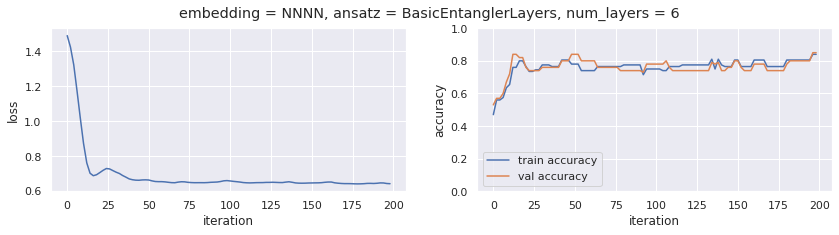

In [54]:
for num_layers in (2, 4, 6):
    train_val_loop(
        weights_shape=(num_layers, dev.num_wires),
        label=f"embedding = NNNN, ansatz = BasicEntanglerLayers, num_layers = {num_layers}"
    )

The Angluar Embedding is giving good results. Using just 4 layers gives good enough result. We'll limit it to 4 layers in the future.

In [55]:
dev = qml.device('default.qubit', wires=3)

@qml.qnode(dev)
def circuit(weights, features):
    NAAN(features)

    qml.BasicEntanglerLayers(weights, wires=range(dev.num_wires))

    return qml.expval(qml.PauliZ(0))

100%|██████████| 200/200 [07:45<00:00,  2.33s/it]


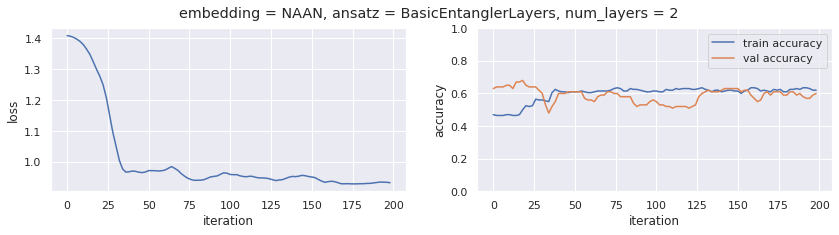

100%|██████████| 200/200 [11:53<00:00,  3.57s/it]


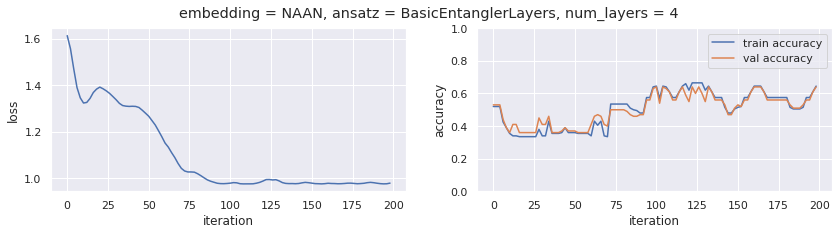

100%|██████████| 200/200 [18:08<00:00,  5.44s/it]


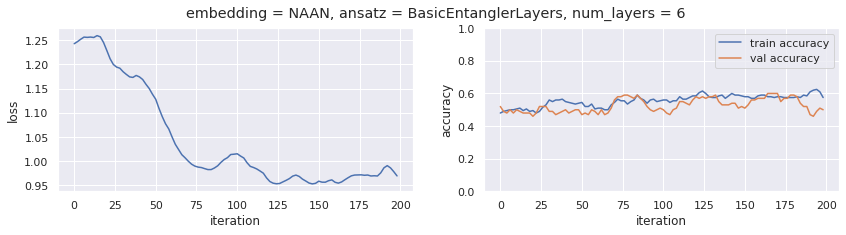

In [56]:
for num_layers in (2, 4, 6):
    train_val_loop(
        weights_shape=(num_layers, dev.num_wires),
        label=f"embedding = NAAN, ansatz = BasicEntanglerLayers, num_layers = {num_layers}"
    )

The `NAAN` encoding scheme doesn't perform very well in this scenario.

In [57]:
dev = qml.device('default.qubit', wires=3)

@qml.qnode(dev)
def circuit(weights, features):
    ANNA(features)

    qml.BasicEntanglerLayers(weights, wires=range(dev.num_wires))

    return qml.expval(qml.PauliZ(0))

  0%|          | 0/200 [00:00<?, ?it/s]/home/aadam/miniconda3/envs/qhack/lib/python3.9/site-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)
100%|██████████| 200/200 [11:36<00:00,  3.48s/it]


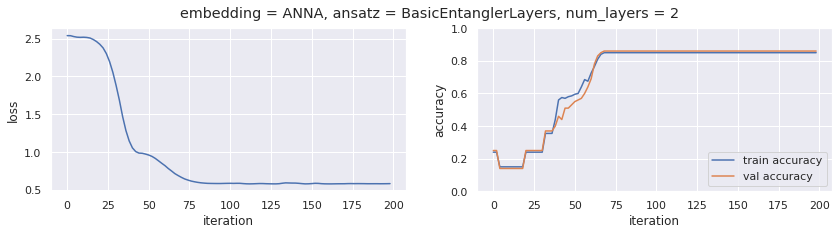

100%|██████████| 200/200 [17:29<00:00,  5.25s/it]


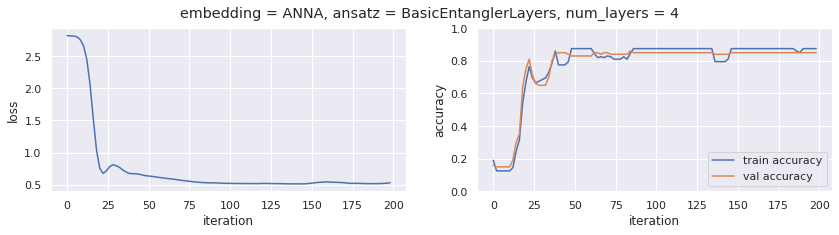

100%|██████████| 200/200 [25:19<00:00,  7.60s/it]


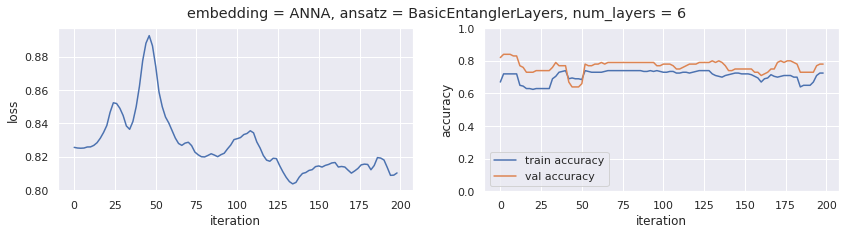

In [58]:
for num_layers in (2, 4, 6):
    train_val_loop(
        weights_shape=(num_layers, dev.num_wires),
        label=f"embedding = ANNA, ansatz = BasicEntanglerLayers, num_layers = {num_layers}"
    )

This encoding scheme is giving the best result, even with 2 layers. We will be utlizing this for further experiments/results.

## Test Accuracies
Now that we have a general idea of what kind of encoding works best with a particular ansatz, let's train ansatz again, utlizing the better performing models.

Based on previous results, we'll test the following combinations of encoding schemes, number of layers, and ansatz:

| encoding | num_layers |   ansatz   |
| ---------|------------|------------|
| `AAAA`   | $2$          | `RXRYRZ CNOTs` |
| `ANNA`   | $3-5$        | `RXRYRZ CNOTs` |
| `NNNN`   | $3-5$        | `BasicEntanglerLayers` |
| `ANNA`   | $2$          | `BasicEntanglerLayers` |

### `RXRYRZ CNOTs`
We'll only use the `AAAA` and `ANNA` encoding scheme, where `A` represents `Amplitude Encoding` and `N` represents `Angular Encoding`, as these two are the ones giving a better results as evident from the experiments above.

First, let's use the `AAAA` encoding and see how well it performs on the test dataset. We're only using $2$ layers because they seem to work well enough, as shown in the experiments above.


In [59]:
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def circuit(weights, features):

    AAAA(features)

    # repeatedly apply each layer in the circuit
    for i in range(weights.shape[1]):
        layer(weights, i)

    return qml.expval(qml.PauliZ(0))

100%|██████████| 150/150 [09:05<00:00,  3.64s/it]


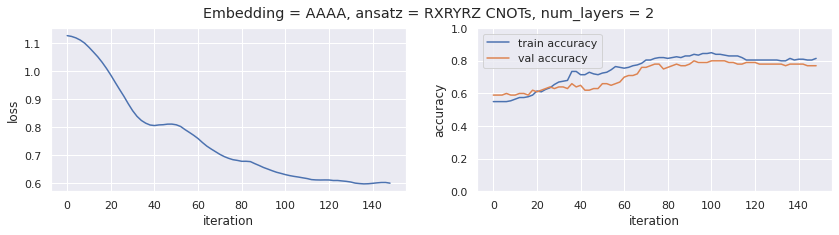

In [60]:
weights, bias = train_val_loop(
    weights_shape=(dev.num_wires, 2, 3),
    label=f"Embedding = AAAA, ansatz = RXRYRZ CNOTs, num_layers = 2",
    num_iter=150
)

In [61]:
test_transformed = transform_data(test_data)
X_test = test_transformed[range(4)].to_numpy()
y_test = test_transformed[4].to_numpy() * 2 - 1

predictions_test = [
    np.sign(variational_classifier(weights, bias, f)) for f in X_test
]

acc_test = accuracy(y_test, predictions_test)
print(f"Test accuracy: {acc_test:.3f}")

Test accuracy: 0.983


We get an accuracy of $98.3 \%$ on the test dataset, which is quite good. 

Now, let's use the `ANNA` encoding scheme and see how it fares. We'll try $3, 4, 5$ layers, as $2$ wasn't performing well before and $4$ did well. Trying out $3$ and $5$ will give us a better understanding of the problem.

In [67]:
dev = qml.device('default.qubit', wires=3)

@qml.qnode(dev)
def circuit(weights, features):

    ANNA(features)

    # repeatedly apply each layer in the circuit
    for i in range(weights.shape[1]):
        layer(weights, i)

    return qml.expval(qml.PauliZ(0))

100%|██████████| 150/150 [13:54<00:00,  5.56s/it]


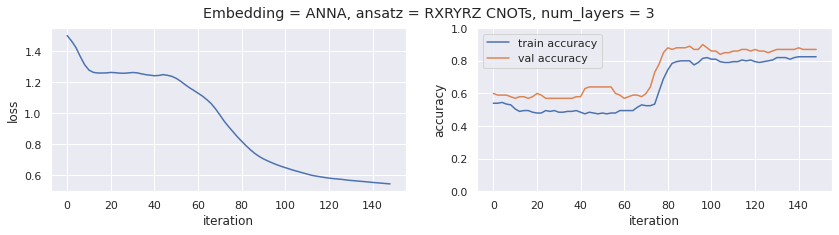

100%|██████████| 150/150 [17:33<00:00,  7.02s/it]


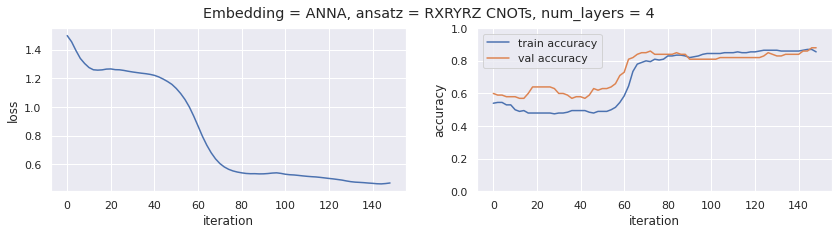

100%|██████████| 150/150 [21:17<00:00,  8.52s/it]


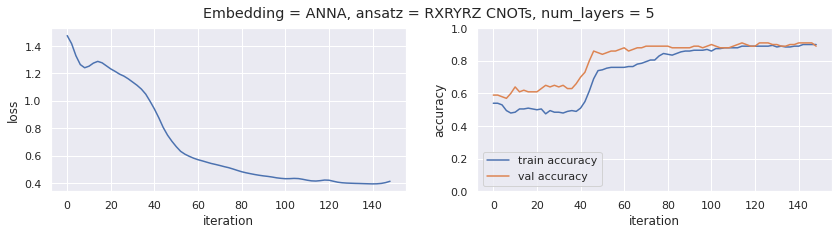

In [69]:
weights_biases = {}

for num_layers in (3, 4, 5):
    weights_biases[num_layers] = train_val_loop(
        weights_shape=(dev.num_wires, num_layers, 3),
        label=f"Embedding = ANNA, ansatz = RXRYRZ CNOTs, num_layers = {num_layers}",
        num_iter=150
    )

In [78]:
for num_layers in weights_biases:
    predictions_test = [
        np.sign(variational_classifier(weights_biases[num_layers][0], weights_biases[num_layers][1], f)) for f in X_test
    ]

    acc_test = accuracy(y_test, predictions_test)
    print(f"{num_layers} layers Test accuracy: {acc_test:.3f}")

3 layers Test accuracy: 0.933
4 layers Test accuracy: 0.975
5 layers Test accuracy: 0.983


The best accuracy we get from this experiment is with $5$ layers, i.e. $98.3 \%$.

### `BasicEntanglerLayers`
Now, let's find out the test accuracies using the `BasicEntanglerLayers` ansatz.

Starting off with `NNNN` scheme.

In [84]:
dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev)
def circuit(weights, features):
    NNNN(features)

    qml.BasicEntanglerLayers(weights, wires=range(dev.num_wires))

    return qml.expval(qml.PauliZ(0))

100%|██████████| 150/150 [09:14<00:00,  3.69s/it]


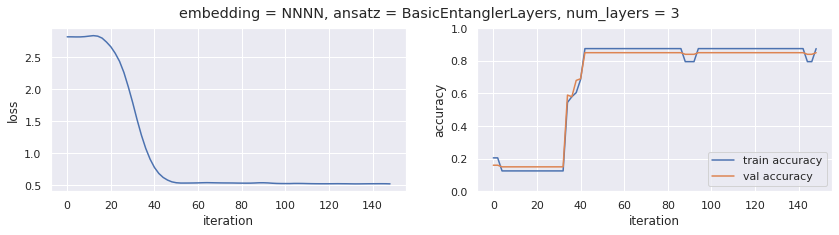

100%|██████████| 150/150 [10:51<00:00,  4.34s/it]


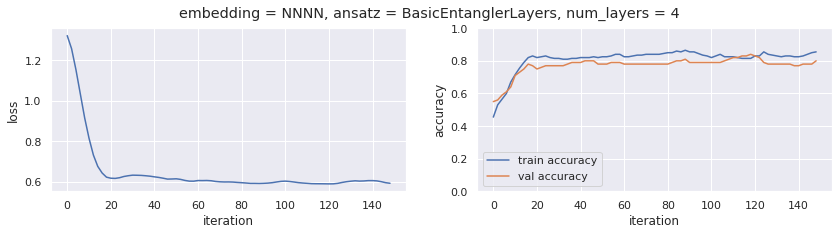

100%|██████████| 150/150 [12:47<00:00,  5.12s/it]


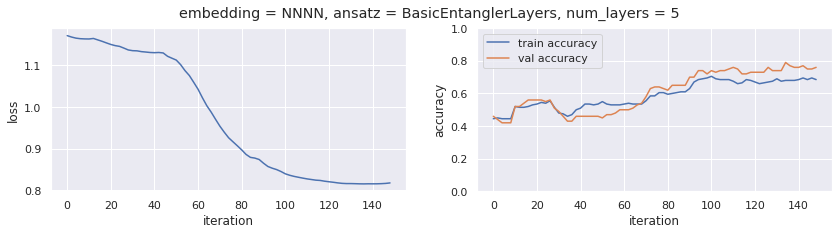

In [85]:
weights_biases = {}

for num_layers in (3, 4, 5):
    weights_biases[num_layers] = train_val_loop(
        weights_shape=(num_layers, dev.num_wires),
        label=f"embedding = NNNN, ansatz = BasicEntanglerLayers, num_layers = {num_layers}",
        num_iter=150
    )

In [86]:
for num_layers in weights_biases:
    predictions_test = [
        np.sign(variational_classifier(weights_biases[num_layers][0], weights_biases[num_layers][1], f)) for f in X_test
    ]

    acc_test = accuracy(y_test, predictions_test)
    print(f"{num_layers} layers Test accuracy: {acc_test:.3f}")

3 layers Test accuracy: 0.942
4 layers Test accuracy: 0.883
5 layers Test accuracy: 0.775


With `BasicEntanglerLayers` and `NNNN` encoding scheme, $3$ layers give us the best accuracy of $94.2 \%$.

Now let's try the `ANNA` encoding scheme.

In [87]:
dev = qml.device('default.qubit', wires=3)

@qml.qnode(dev)
def circuit(weights, features):
    ANNA(features)

    qml.BasicEntanglerLayers(weights, wires=range(dev.num_wires))

    return qml.expval(qml.PauliZ(0))

100%|██████████| 150/150 [04:25<00:00,  1.77s/it]


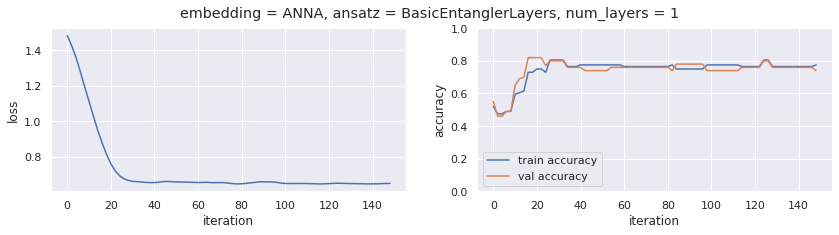

100%|██████████| 150/150 [05:55<00:00,  2.37s/it]


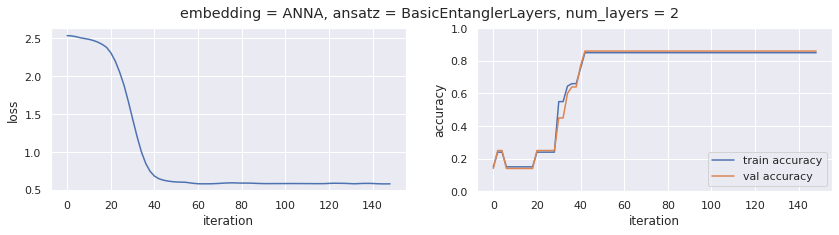

In [90]:
weights_biases = {}

for num_layers in (1, 2):
    weights_biases[num_layers] = train_val_loop(
        weights_shape=(num_layers, dev.num_wires),
        label=f"embedding = ANNA, ansatz = BasicEntanglerLayers, num_layers = {num_layers}",
        num_iter=150
    )

In [91]:
for num_layers in weights_biases:
    predictions_test = [
        np.sign(variational_classifier(weights_biases[num_layers][0], weights_biases[num_layers][1], f)) for f in X_test
    ]

    acc_test = accuracy(y_test, predictions_test)
    print(f"{num_layers} layers Test accuracy: {acc_test:.3f}")

1 layers Test accuracy: 0.808
2 layers Test accuracy: 1.000


With this encoding scheme, we get the accuracy of $100 \%$ with $2$ layers.

# Summary
Here, we have experimented with different data encoding schemes and ansatz to figure out which particular combination of encoding schemes, ansatz, and number of layers give us the best result. For the purpose of this experiment, I've decided to use two encoding schemes, `Amplitude Encoding (A)` and `Angular Encoding (N)`, and two ansatz, one with `RX RY RZ + CNOT` gates and the other one being the `BasicEntanglerLayers` provided in the PennyLane library.

I first ran some preliminary experiments to see which encoding scheme and number of layers give a relatively better result. Based on those experiments, I chose some better performing combinations, and further experimented with different number of layers to see which one works well. The result from these experiments are shown in the table below:

| Encoding Scheme | Ansatz | Numeber of Layers | Test Accuracy (%) | Training Time (MM:SS) |
| ----------------|--------|-------------------|---------------|-----------------------|
| `ANNA` | `BasicEntanglerLayers` | 2 | 100 | 05:55 |
| `AAAA` | `RXRYRZ CNOTs` | 2 | 98.3 | 09:05 |
| `ANNA` | `RXRYRZ CNOTs` | 5 | 98.3 | 21:17 |
| `NNNN` | `BasicEntanglerLayers` | 3 | 94.2 | 09:14 |

For this particular problem, the best settings were that of the first row, i.e. low number of layers, maximum accuracy and minimum training time. 
